# <center>CITS5508 Lab sheet 4</center>

**Name: Zhanhong He** (or Zhanh He)<br>
**Student number: 22597343**<br>
**Date created:** 15 April 2021<br>
**Last modified:** 23 April 2021<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

# Project 1 Abalone Dataset

Project 1 is using the **Abalone dataset** [1] supplied on the [UCI Centre for Machine Learning and Intelligent Systems](http://archive.ics.uci.edu/ml/datasets/Abalone).The dataset includes following information.
>1. `Sex` / nominal / -- / M, F, and I (infant)
>2. `Length` / continuous / mm / Longest shell measurement
>3. `Diameter` / continuous / mm / perpendicular to length
>4. `Height` / continuous / mm / with meat in shell
>5. `Whole weight` / continuous / grams / whole abalone
>6. `Shucked weight` / continuous / grams / weight of meat
>7. `Viscera weight` / continuous / grams / gut weight (after bleeding)
>8. `Shell weight` / continuous / grams / after being dried
>9. `Rings` / integer / -- / +1.5 gives the age in years
> **Reference:** 
> [1]: Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD thesis, Computer Science Department, University of Tasmania.

## Task 1. Reading, Data cleaning

Task 1 is composed of:<br>
+ 1.1 Read, inspect and visualise `abalone.data` file 
+ 1.2 Using `features correlation matrix` to remove **2 features** <br>
+ 1.3 Relabel the `Sex` column, then using `one-hot endcoding` to convert

### 1.1 Read the data
According to the dataset description, we know:
>1. Number of Columns: **9**
>2. Number of Instances: **4177**
>3. Number of Attributes: **8**
>4. Missing Attribute Values: **None**


Select these columns, we can apply `head()` to inspect what instances they have

In [2]:
# 1.1 - Read and inspect the abalone.data file

# Read the data
column_names = ["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"]
data = pd.read_csv('abalone.data',names=column_names)

# Inspect the data
data.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


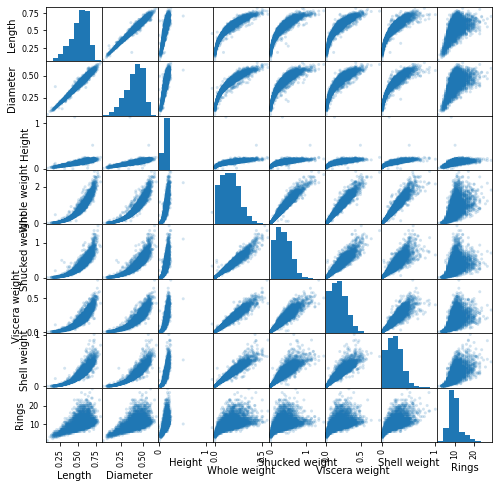

In [3]:
# Features visualisation
scatter_matrix(data[column_names],alpha=0.2,figsize=(8,8))
plt.show()

### 1.2 Features Correlation (Data Cleaning)
Using `corr()` function to provide the features **correlation matrix**, as the support material of scatter matrix to help us decide **what features can be removed**.

In [4]:
# 1.2 - Features Correlation Matrix
corr_matrix = data.corr()
corr_matrix

# Features correlations to Rings
# corr_matrix['Rings'].sort_values(ascending=True)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
Length,1.000000,0.986812,0.827554,0.925261,0.897914,0.903018,0.897706,0.556720
Diameter,0.986812,1.000000,0.833684,0.925452,0.893162,0.899724,0.905330,0.574660
Height,0.827554,0.833684,1.000000,0.819221,0.774972,0.798319,0.817338,0.557467
Whole weight,0.925261,0.925452,0.819221,1.000000,0.969405,0.966375,0.955355,0.540390
Shucked weight,0.897914,0.893162,0.774972,0.969405,1.000000,0.931961,0.882617,0.420884
Viscera weight,0.903018,0.899724,0.798319,0.966375,0.931961,1.000000,0.907656,0.503819
Shell weight,0.897706,0.905330,0.817338,0.955355,0.882617,0.907656,1.000000,0.627574
Rings,0.556720,0.574660,0.557467,0.540390,0.420884,0.503819,0.627574,1.000000


According to the *Scatter Matrix* and *Corelation Matrix*, the **first feature to remove** is `Diameter` because:
+ `Diameter` is linearly correlated to the *Length* in the scatter matrix
+ `Diameter` and *Length* have the similar correlation with others feature as shown in the correlation matrix

So we can only keep the *Length* and remove the `Diameter` with the least impact. The **second feature to remove** is `Whole weight` because:
+ `Whole weight` has the high correlation with most of the features (both weight and length).

Which means the `Whole weight` can be represented by the other weigth features, so remove `Whole weight` has the less impact.

In [5]:
# Remove two features with lowest correlation
data_removed = data.drop(columns=['Diameter','Whole weight'])
data_removed.head(5)

,Sex,Length,Height,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.095,0.2245,0.1010,0.150,15
1,M,0.350,0.090,0.0995,0.0485,0.070,7
2,F,0.530,0.135,0.2565,0.1415,0.210,9
3,M,0.440,0.125,0.2155,0.1140,0.155,10
4,I,0.330,0.080,0.0895,0.0395,0.055,7


### 1.3 One-Hot Encoding (Data Cleaning)
Among the `Sex` column, replace `M` and `F` instances with `A` (adult). Machines are more sensetive to the numerical data, to better handle the *str* content, we using `OneHotEncoder` to convert `Sex` into numerical columns.

In [6]:
# 1.3 - One-Hot Encoding

# Replace M and F with A
data_clean = data_removed.replace(['M','F'],'A')

# Obtain numerical arrays by OneHotEncoding
sex_encoder = OneHotEncoder()
sex_hot = sex_encoder.fit_transform(data_clean[['Sex']])
sex_hot_array = sex_hot.toarray()

# Replace origin values of Sex
data_clean['Sex'] = sex_hot_array
data_clean.head(5)

,Sex,Length,Height,Shucked weight,Viscera weight,Shell weight,Rings
0,1.0,0.455,0.095,0.2245,0.1010,0.150,15
1,1.0,0.350,0.090,0.0995,0.0485,0.070,7
2,1.0,0.530,0.135,0.2565,0.1415,0.210,9
3,1.0,0.440,0.125,0.2155,0.1140,0.155,10
4,0.0,0.330,0.080,0.0895,0.0395,0.055,7


## Task 2. Features Scaling and Train Test Split

Tast2 is composed of:<br>

+ 2.1 Perform features scaling (with Standard Scaler)
+ 2.2 Perform 85/15 train test data split. 

As mentioned above `Rings` is our prediction target, so the other features are using for the train set. Since the Support Vector Machine is sensitive of features scaling, refer to previous Lab, here should use the **Standard Scaler** to nomalisate the training data set.  After that, using **85/15 ratio** to split the train and test set.

In [7]:
# 2.1 - Peform features scaling

target = data_clean['Rings']
train = data_clean.drop(columns='Rings')

# Standard Scaler
std_scale = StandardScaler().fit(train)
std_train = std_scale.transform(train)

# 2.2 -  Perform 85/15 Train Test Split
train_x,test_x,train_y,test_y = train_test_split(std_train,target,test_size=0.15,random_state=4)

## Task 3. Prepare AdaBoost Regressor
Task 3 is composed of:

+ 3.1 Prepare AdaBoost Regressor with SVR and RBF kernel; **4 or 5 Estimators** under the ensemble
+ 3.2 Optimize `C` and `gamma` of RBF SVR; `learning_rate` and `loss` of AdaBoost Regressor.

Using **GridSearchCV** to explore the best hyperparameter (3-fold cross validation is prepared for the Project 2). 
+ To obtain the best mean absolute error from regressors prediction, setting the `scoring='neg_mean_absolute_error'`. 

The follow hyperparameters are used in the Grid Search:
+ *RBF kernel SVRegressor:* `C = [0.1, 100]` and `gamma = [0.0001, 10] or ['scale','auto']` will decide the decision boundary.
+ *AdaBoost Regressor:* `learning_rate` shrinks the contribution of each regressor; `loss` is the function updating the weights after each boosting iteration.

In [8]:
# 3.1 - Prepare AdaBoost regressor

# Use Support Vector Regressor with RBF kernel
svr = SVR(kernel='rbf')

# Optimize RBF SVM parameters
param_svr = {'C':[5,10,15],
             'gamma':['scale','auto']} # or [0.001,0.01,0.1]

# Four (or Five) Estimators under the AdaBoost Regressor ensemble
ada = AdaBoostRegressor(base_estimator=svr, n_estimators=4, random_state=1)

# Optimize Adaboost parameters
param_ada = {'learning_rate': [0.5,0.8,1],
             'loss': ('linear','square','exponential')}

In [9]:
# 3.2 - Optimize the Regressor with Grid Search

def grid_search(model,parameters,train,target):
    '''
    model: svr, ada, forest(Project2)
    parameters: param_svr, param_ada, param_forest(Project2)
    train: train
    target: target
    '''
    # Find the Regressor parameters to obtain the best MAE
    clf = GridSearchCV(model, parameters,cv=3,scoring ='neg_mean_absolute_error')
    clf.fit(train,target) # cv=3 is prepared for Project 2
    
    # Best Hyperparameters - Grid Search
    print('\nBest hyperparameters:',clf.best_params_)
    return

# Grid Search the best parameters

# grid_search(svr,param_svr,std_train,target)
# grid_search(ada,param_ada,train,target)

From the **Grid Search** we obtain the best parameters for Support Vector Regressor and AdaBoost Regressor:
+ Best RBF SVRegressor: {'C': 5, 'gamma': 'scale'}
+ Best AdaBoost Regressor: {'learning_rate': 0.5, 'loss': 'exponential'}

where **AdaBoost Regressor random_state=1**.

Also, the results of repeated tuning hyperparameters show that AdaBoost Regressor using **n_estimator = 4 is more accurate than 5**. Considering that the 4th result is good enough, it is understandable that the 5th iteration makes the result worse, which should be avoided.
+ n_estimators = 4 is more likely to obtain the accurate results

We apply the above hyperparameters to obtain the better predictied results.

In [10]:
# Support Vector Regressor - Best Parameters
svr = SVR(kernel='rbf',C=5,gamma='scale')

# AdaBoost Regressor - Best Parameters
ada = AdaBoostRegressor(base_estimator=svr, n_estimators=4,
                        learning_rate=0.5, loss='exponential', random_state=1)

## Task 4. Regressor Predicted Results
Task 4 is use a function to summarise all predicted outputs from the ensemble regressors:
+ all the imtermediate and final models.

The regressor predicted results **must be integers**.

In [11]:
def pred_results(regressor,train_x,test_x,train_y,test_y):
    
    # Summarise staged predictions for all estimators of regressor
    results = {'train_y': train_y, 'pred_train_y': [],
               'test_y' : test_y , 'pred_test_y':  []}
    # Fit the regressor
    regressor.fit(train_x, train_y)

    # Each estimators prediction on the training set
    for y_stage in regressor.staged_predict(train_x):
        # Predictied results must be integers
        pred_y = np.round(y_stage)
        results['pred_train_y'].append(pred_y)
   
    # Each estimators prediction on the test set
    for y_stage in regressor.staged_predict(test_x):
        # Predictied results must be integers
        pred_y = np.round(y_stage)
        results['pred_test_y'].append(pred_y)
    
    return results

In [12]:
# 4 - Adaboost Regressor Predicted Results
results1 = pred_results(ada,train_x,test_x,train_y,test_y)

## Task 5. Report the MAEs
Task 5 is composed of:

+ 5.1 Report the Numerical MAEs
+ 5.2 Report the Graphical MAEs (in the same graph)

Representing the AdaBoost Regressor predictied results on **Train Set** and **Test Set**, respectively.

In [13]:
def MAEs_numerical(results):
    
    # Summarise the mean square error of each iteration (staged pred)
    MAEs = {'train': [],
            'test' : []}
    
    # Calculate MAEs on the training set
    for pred_y in results['pred_train_y']:
        MAEs['train'].append(mean_absolute_error(results['train_y'], pred_y))
        
    # Calculate MAEs on the test set
    for pred_y in results['pred_test_y']:
        MAEs['test'].append(mean_absolute_error(results['test_y'], pred_y))
        
    # Print numerical results of all the intermediate and the final models
    num = len(MAEs['train'])
    for i in range(0,num):
        print("No.%d predicted results:\nTrain Set MAE: %f \nTest Set MAE: %f \n"
              %(i+1,MAEs['train'][i],MAEs['test'][i]))
    
    return MAEs

In [14]:
# 5.1 - Numerical MAEs
MAEs1 = MAEs_numerical(results1)

No.1 predicted results:
Train Set MAE: 1.414366 
Test Set MAE: 1.417863 

No.2 predicted results:
Train Set MAE: 1.414366 
Test Set MAE: 1.417863 

No.3 predicted results:
Train Set MAE: 1.409296 
Test Set MAE: 1.414673 

No.4 predicted results:
Train Set MAE: 1.409296 
Test Set MAE: 1.414673 



In [15]:
def MAEs_graphical(MAEs):
    # Define the number of iteration
    num = len(MAEs['train'])

    # Scatter plot each iteration's Train and Test MAEs
    plt.scatter(np.arange(num),MAEs['train'])
    plt.scatter(np.arange(num),MAEs['test'])
    plt.plot(MAEs['train'], label="Train MAE")
    plt.plot(MAEs['test'], label="Test MAE")
    
    # Label the graph
    plt.title('Adaboost Regressor MAEs')
    plt.xlabel('Iteration predicted results')
    plt.xticks(np.arange(num),np.arange(1,num+1))
    plt.ylabel('Mean Absolute Errors')
    plt.legend()

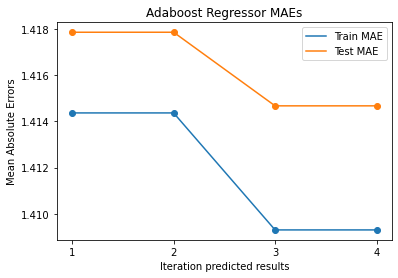

In [16]:
# 5.2 - Graphical MAEs
MAEs_graphical(MAEs1)

## Task 6. Predictied Results Graph
Task 6 is use the **linear regression graphs** to illustrate the regressor predicted results. Those regressor predictions will compare with the ground truth (target true values).
+ One purpose is to evaluate the quality of the prediction
+ The other purpose is to evaluate whether the regressor is overfitting

By inputting the predicted results, the code will results **two subplot**, one for the train set prediction, and the other for the test set prediction. By observing the predicted results's linear regression graphs, we can conclude that：
+ Our AdaBoost Regressor final model predicted results is good, and does not overfitting

In [17]:
def pred_results_graph(results,lims):
    
    # Divide one figure into two subplot
    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    axL = ax[0]; axR = ax[1]
    fig.suptitle('Regressor Predictions vs Ground Truth', fontsize=16)
    
    # Left subplot for Train Set Prediction
    plotL = axL.scatter(results['train_y'],results['pred_train_y'][-1],alpha = 0.2)
    axL.set_alpha = 0.1
    axL.set_xlim(lims); axL.set_ylim(lims); axL.plot(lims,lims)  # Diagonal line
    axL.set_xlabel('Target True Values')
    axL.set_ylabel('Regressor Predictions')
    axL.set_title('Train Set Predicted Results')
    
    # Right subplot for Test Set Prediction
    plotR = axR.scatter(results['test_y'],results['pred_test_y'][-1],alpha = 0.2)
    axR.set_alpha = 0.1
    axR.set_xlim(lims); axR.set_ylim(lims); axR.plot(lims,lims) # Diagonal line
    axR.set_xlabel('Target True Values')
    axR.set_ylabel('Regressor Predictions')
    axR.set_title('Test Set Predicted Results')

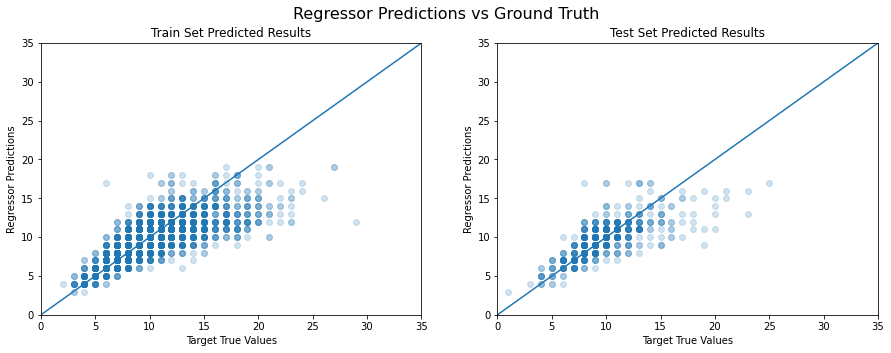

In [18]:
# 6 - Predicted Results Graph
pred_results_graph(results1,[0,35])

## Task 7. Raw Prediction Errors Distribution
From the labsheet requirement:
+ Select the results of the final model only.
+ Illustrate **raw errors distribution** with the **bar chart**. 
+ We should reuse these code in the Project 2.

The following Code will plot the Bar Chart to represent the distribution of raw prediction errors. Furthermore, it also report the **average relative error rate** for better understanding the distribution.
+ This value should averge 7-10% according to the Labsheet. However, I suspect **7-10% is the overfitting result**.
+ When I used Grid Search or manutal tunning the hyperparameter, the **well-fit results are always around 14%**.

In [19]:
def raw_error(results,labels,x_range):
    
    # Select the final model only, calculate the raw errors
    final_train_y = results['pred_train_y'][-1]
    final_test_y = results['pred_test_y'][-1]
    error_train = final_train_y - results['train_y']
    error_test = final_test_y - results['test_y']
        
    # Define the Bar heights, count the raw errors into bar heights
    h_train = []; h_test = []
    for x in x_range:
        h_train.append((x==error_train).sum())
        h_test.append((x==error_test).sum())
        
    # Calculate the Relative error rates
    error_rate_train = abs(error_train/results['train_y'])
    error_rate_test = abs(error_test/results['test_y'])
    re_train = sum(error_rate_train)/len(error_rate_train)
    re_test = sum(error_rate_test)/len(error_rate_test)
        
    # Report the Relative error rates
    print('\n%s'%(labels))
    print(f'Average relative error rate on Train Set: {100*re_train:.4f}%')
    print(f'Average relative error rate on Test Set: {100*re_test:.4f}%')
       
    # Report the Bar heights
    return h_train, h_test

In [20]:
def plot_raw_error(h1_train,h1_test,h2_train,h2_test,labels,x_range):

    # Bar Charts: Left graph for Train Set, Right graph for Test Set
    fig, ax = plt.subplots(ncols=2,figsize=(15,5))
    axL = ax[0]; axR = ax[1]
    
    # Plot first predicted results
    if len(labels)==1:
        '''The 1st and only predicted results'''
        width = 1/2;
        plotL = axL.bar(x_range, h1_train, width, label=labels[0])
        plotR = axR.bar(x_range, h1_test, width, label=labels[0])
    
    # Plot first/second predicted results comparison
    elif len(labels)==2:
        '''The 1st and 2nd predicted results comparison '''
        width = 1/2; 
        plotL_1 = axL.bar(x_range - width/2, h1_train, width, label=labels[0])
        plotL_2 = axL.bar(x_range + width/2, h2_train, width, label=labels[1])
        plotR_1 = axR.bar(x_range - width/2, h1_test, width, label=labels[0])
        plotR_2 = axR.bar(x_range + width/2, h2_test, width, label=labels[1])
        
    # Label the Bar Charts
    axL.set_xlabel('Raw Error Distributions');axL.set_ylabel('Occurrences')
    axL.set_title('Train Set Raw Prediction Errors')
    axL.legend(); axL.grid()
    axR.set_xlabel('Raw Error Distributions');axR.set_ylabel('Occurrences')
    axR.set_title('Test Set Raw Prediction Errors')
    axR.legend(); axR.grid()
    
    return


AdaBoost Regressor using RBF SVM
Average relative error rate on Train Set: 13.5709%
Average relative error rate on Test Set: 14.1599%


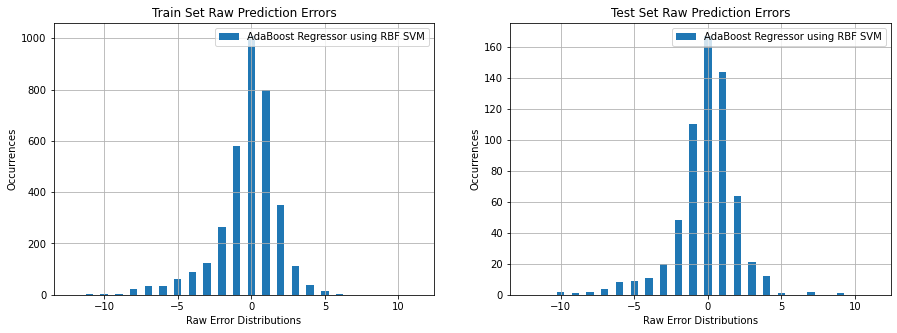

In [21]:
# Define the error range and labels
x_range = np.arange(-12,12)          
labels = ['AdaBoost Regressor using RBF SVM']

# The 1st and only predicted results
h1_train, h1_test = raw_error(results1,labels[0],x_range) 
h2_train, h2_test = h1_train, h1_test

# Plot the distribution
plot_raw_error(h1_train,h1_test,h2_train,h2_test,labels,x_range)

I tunned the parameters of the SVM to improve the fitting on the Train Set, resulting in the **8% relative error rate** as shown below.
+ But obviously, this prediction is an **overfitting** result, because this regressor obtain the poor predict performance on the Test Set （18% relative error rate).

If the Regressor is well fit, the raw errors distribution on the Train and Test set should be similar. Otherwise we can only conclude that Regressor is overfitting to the Train Set, as shown above. Therefore,
+ **Approx.14%** relative error rate should be the **reasonable** result.
+ **7-10%** relative error rate is high likely the **overfitting** result.


Overfitting(Train Set)
Average relative error rate on Train Set: 8.1040%
Average relative error rate on Test Set: 18.5706%


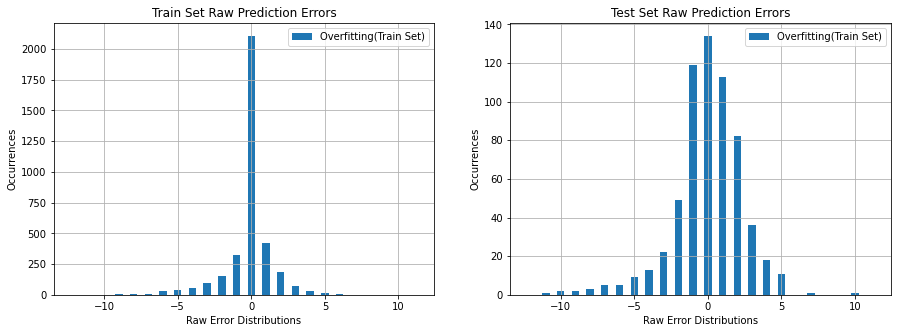

In [22]:
# 7-10% relative error rate example - suspected of overfitting
svr = SVR(kernel='rbf',C=5,gamma=10)
ada = AdaBoostRegressor(base_estimator=svr,n_estimators=4,learning_rate=0.5,loss='exponential',random_state=1)

results1 = pred_results(ada,train_x,test_x,train_y,test_y)
x_range = np.arange(-12,12);labels = ['Overfitting(Train Set)']
h1_train, h1_test = raw_error(results1,labels[0],x_range) 
h2_train, h2_test = h1_train, h1_test

plot_raw_error(h1_train,h1_test,h2_train,h2_test,labels,x_range)


## Task 8. Train/Test Set Predicted Results Comparison
From the **Task5 MAEs comparsion graph**,
1. The MAEs on the Train Set are always lower than the Test Set (the lower, the better). This is because the Train Set has more data than the Test Set. Using more data should have better predicted results, otherwise it can only be regarded as an occasional event or overfitting occur.
2. Both Train and Test Set MAEs are reduced with the iteration increases. However, it doesn't mean that more estimators will always give the better predicted results. If the estimators is too much, the resuls can be worse or even become overfitting.
3. In my experiment, the n_estimator = 4 obtain the better predictions (MAEs) than n_estimator = 5.

From the **Task6 Predicted Result graphs**,
1. Both predited results on the Train and Test Set are approximating to the linear regression line, which means the Regressor predict performance is good.
2. By observing the graph, we know our AdaBoost Regressor is not overfitting (when relative error rate around 14%).

From the **Task7 Raw Errors Distribution graphs**,
1. Refer to the graph, the prediction on the Train Set always better than the Test Set. Same reason as the MAEs, this is the reasonable phenomenon.
2. After tunning the hyperparameters, the relative errors rate is within the 7-10%, but this is likely the overfitting result.
3. The reasonable relative error rate should be 14% around.
4. Some predictions have exceed +/- 2 raw errors, but considering we have a large amount of instances (4177), the slight deviation is acceptable.

# Project 2. Red Wine Dataset
Project 1 is using the **Wine Quality Dataset** [1] supplied on the [UCI Centre for Machine Learning and Intelligent Systems](https://archive.ics.uci.edu/ml/datasets/wine+quality).The dataset includes following information.
>1. Number of Columns: 12
>2. Number of Instances(Red Wine): 1599
>3. Number of Attributes: 11 inputs + 1 output
>4. Missing Attribute Values: None
>5. Inputs: `fixed acidity`, `volatile acidity`, `citric acid`, `residual sugar`, `chlorides`, `free sulfur dioxide`, `total sulfur dioxide`, `density`, `pH`, `sulphates`, `alcohol`
>6. Output:`quality` score between 0 and 10 (predict target)
>
> **Reference:** <br>
> [1]: P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

## Task 1. Random Forest Regressor with Original Data

Task 1 is composed of:<br>
+ 1.1 Reading, Data Cleaning, and Train/Test Split
+ 1.2 Random Forest Regressor and Predicted Results
+ 1.3 Report MAEs numerically and Predicted Results Graph
+ 1.4 Report Raw Errors Distribution (Bar Charts)

### 1.1 Reading, Data Cleaning, and Train/Test Split
For the Red Wine Dataset, we **don't focus on data cleaning** because:
+ All attributes are numerical values.
+ There are not missing values.
+ Refer to **Correlation Matrix**, input features doesn't have strong correlation between each other.

Then, we directly exact the `quality` as the target set, then perform the train/test split. The Random Forest Regressor (Decision Tree) is not sensitive with the features scaling, so we **don't process the normalisation** here.

In [23]:
# 1.1 - Reading and Cleaning

# Read the data file
data = pd.read_csv('winequality-red.csv',sep=";",skipinitialspace=True)
# data.head(5)

# Skip the data cleaning
data.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


In [24]:
# Divide train and target attributes
target = data['quality']
train = data.drop(columns='quality')

# Perform 85/15 Train/Test Split
train_x,test_x,train_y,test_y = train_test_split(train,target,test_size=0.15,random_state=7)

### 1.2 Random Forest Regressor and Predicted Results
During the parameters optimizing, our 3 hyperparameters used in the Random Forest Regressor are:
+ `n_estimators`: The maximum number of estimators at which boosting is terminated, can stopped early to avoid prefect fit.
+  Many Decision Tree hyperparameters can be used here, so select two of them to perform the **3-fold cross validation grid search**.
+ `min_samples_leaf` is the minimum number of samples a leaf node must have.
+ `max_features`is the maximum number of features that are evaluated for splitting at each node.

According to the Grid Search result, the best hyperparameters for Random Forest Regressor is
+ **Same Code**: `grid_search` has been defined in the Project 1 Task 3.
+ Best RFRegressor: {'max_features': 4, 'min_samples_leaf': 10, 'n_estimators': 500}.

where the **RandomForestRegressor random_state=0**. We apply these parameters for the better prediction. Different with Project 1, the Random Forest Regressor doesn't not support the stage prediction, so we need to write a new function to get the predicted results.
+ **Different Code**: `pred_results` is changed here

In [25]:
# Use Random Forest Regressor
forest = RandomForestRegressor(random_state=0)

# Optimize RF Regressor parameters
param_forest = {'n_estimators': [300, 400, 500],
                'max_features': [1, 3, 4],
                'min_samples_leaf': [1, 5, 10]}

# Grid Search the best parameters
# grid_search(forest,param_forest,train,target)

# Best parameters from Grid Search
forest = RandomForestRegressor(max_features=4,min_samples_leaf=10,n_estimators=500,random_state=0)

In [26]:
def pred_results(regressor,train_x,test_x,train_y,test_y):
    
    # Summarise all predicted results in the forest
    results = {'train_y': train_y, 'pred_train_y': [],
               'test_y' : test_y , 'pred_test_y':  []}
    
    # Fit the regressor
    regressor.fit(train_x, train_y)
    
    # Train set predicted results, must be integers
    pred_train_y = np.round(regressor.predict(train_x))
    results['pred_train_y'].append(pred_train_y)
    
    # Test set predicted results, must be integers
    pred_test_y = np.round(regressor.predict(test_x))
    results['pred_test_y'].append(pred_test_y)
    
    return results

In [27]:
# RF Regressor Predicted Results
results1 = pred_results(forest,train_x,test_x,train_y,test_y)

### 1.3 Report MAEs Numerically and Predicted Results Graph
The RF Regressor only report the final model predicted results (i.e. the best results), while other intermediate model are ignored. So this part only report the final model's MAEs on the Train Set prediction and Test Set prediction. The predicted results graph illustrate the regressor prediction performances.
+ **Same Code**: `MAEs_numerical` has been defined in the Project 1 Task 5
+ **Same Code**: `pred_results_graph` has been defined in the Project 1 Task 6

Since the red wine dataset has only 1599 instances, most of the RF Regressor predicted results are nearby the linear regression line, indicating the good accuracy. Observing two subplots, we can conclude that our RF Regressor is not overfitting.

No.1 predicted results:
Train Set MAE: 0.301692 
Test Set MAE: 0.354167 



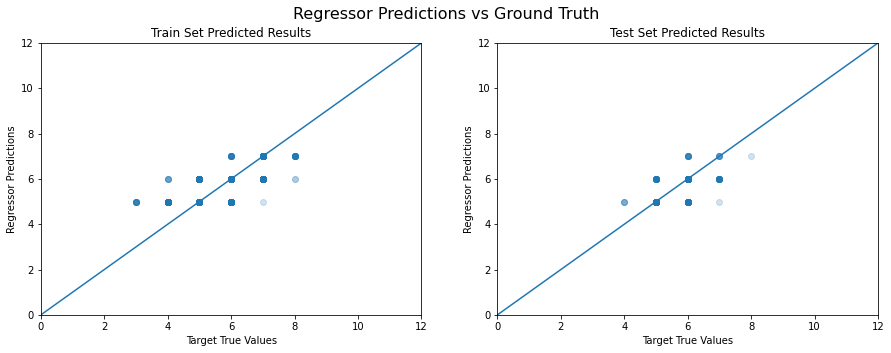

In [28]:
# Numerical MAEs of the final model
MAEs1 = MAEs_numerical(results1)

# Predicted Results Graph of the final model
pred_results_graph(results1,[0,12])

### 1.4 Report Raw Errors Distribution (Bar Charts)

We will plot the Bar Charts to represent the **raw prediction errors distribution**; also report the **average relative error rate** for the comparison.
+ **Same Code**: `raw_error` has been defined in the Project 1 Task 7
+ **Same Code**: `plot_raw_error` has been defined in the Project 1 Task 7


RFRegressor (Origin Dataset)
Average relative error rate on Train Set: 5.5831%
Average relative error rate on Test Set: 6.0937%


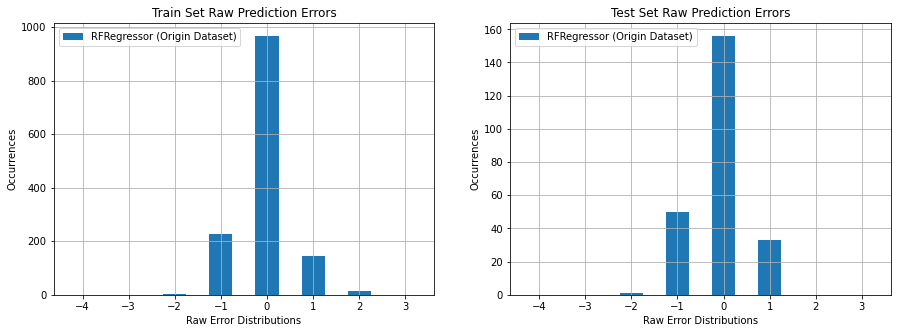

In [29]:
# Define the error range and labels
x_range = np.arange(-4,4)
labels = ['RFRegressor (Origin Dataset)']

# The 1st and only predicted results
h1_train, h1_test = raw_error(results1,labels[0],x_range)
h2_train, h2_test = h1_train, h1_test

# Plot the distribution
plot_raw_error(h1_train,h1_test,h2_train,h2_test,labels,x_range) 

## Task 2. Dimensionality reduction: Using Feature Importances
Task 2 is composed of:<br>
+ Report all features' importance values
+ Report what features should be removed (i.e. importances less than 0.05)
+ Report the reminding features total importance values

In [30]:
# Fit selector with the train and target set
selector = SelectFromModel(estimator=forest,threshold=0.05).fit(train.values,target.values.ravel())

# Report all features importance values
feature_importance = pd.DataFrame(data=selector.estimator.feature_importances_,index=train.columns)
feature_importance = feature_importance.sort_values(by=0,ascending=True)
print("Importances of all input features:\n",feature_importance)

Importances of all input features:
                              0
residual sugar        0.024041
free sulfur dioxide   0.031752
pH                    0.038148
fixed acidity         0.040013
chlorides             0.043944
citric acid           0.053765
density               0.068633
total sulfur dioxide  0.069364
volatile acidity      0.153067
sulphates             0.172868
alcohol               0.304405


In [31]:
# Report what features should be removed
trim_features = feature_importance[feature_importance[0]<0.05]
print("Remove Features with less importances (less than 0.05):\n",trim_features)

# Report the reminding features importance values
print("\nReminding Features total importances values:",1-sum(trim_features[0]))

Remove Features with less importances (less than 0.05):
                             0
residual sugar       0.024041
free sulfur dioxide  0.031752
pH                   0.038148
fixed acidity        0.040013
chlorides            0.043944

Reminding Features total importances values: 0.8221023860428842


## Task 3. Random Forest Regressor with Reduced-Dimensional Data
Task 3 is composed of:<br>
+ Reduce Data Dimension: Trim the features with less importances according to Task 2
+ Report MAEs Numerically and Predicted Results Graph
+ Report Raw Errors Distribution: Plot the predicted results of Origin Dataset and Trim Dataset together for comparison.

In [32]:
# Reduce Data Dimension
trim_train_x = train_x.drop(columns=trim_features.index)
trim_test_x = test_x.drop(columns=trim_features.index)

# Use Trim Data to repeat the train and prediction process
results2 = pred_results(forest,trim_train_x,trim_test_x,train_y,test_y)

No.1 predicted results:
Train Set MAE: 0.316409 
Test Set MAE: 0.362500 



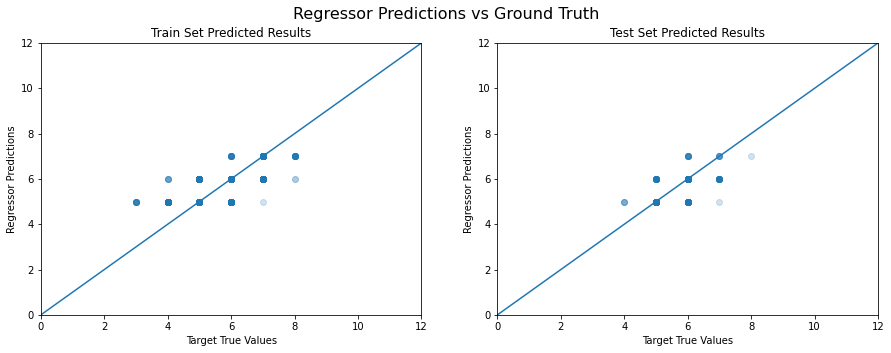

In [33]:
# Report MAEs Numerically
MAEs2 = MAEs_numerical(results2)

# Predicted Results Graph of the final model
pred_results_graph(results1,[0,12])


RF Regressor(Origin Dataset)
Average relative error rate on Train Set: 5.5831%
Average relative error rate on Test Set: 6.0937%

RF Regressor(Trim Dataset)
Average relative error rate on Train Set: 5.8662%
Average relative error rate on Test Set: 6.3041%


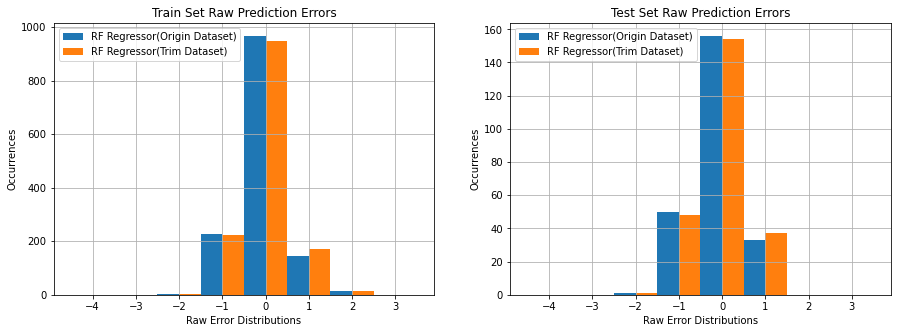

In [34]:
# Define the error range and lanels
x_range = np.arange(-4,4)
labels = ['RF Regressor(Origin Dataset)','RF Regressor(Trim Dataset)']

# The 1st predicted results and 2nd predicted results
h1_train, h1_test = raw_error(results1,labels[0],x_range) 
h2_train, h2_test = raw_error(results2,labels[1],x_range)

# Plot the raw errors distribution (for comparison)
plot_raw_error(h1_train,h1_test,h2_train,h2_test,labels,x_range) 

## Task 4. Origin/Reduced-Dimensional Results Comparison

From the Random Forest Regressor (Origin Dataset) predicted results:
+ Train Set MAE: 0.301692
+ Test Set MAE: 0.354167
+ Average relative error rate on Train Set: 5.5831%
+ Average relative error rate on Test Set: 6.0937%

From the Random Forest Regressor (Trim Dataset) predicted results:
+ Train Set MAE: 0.316409 
+ Test Set MAE: 0.362500 
+ Average relative error rate on Train Set: 5.8662%
+ Average relative error rate on Test Set: 6.3041%

**The RF Regressor predicted results on the Trim Dataset is slightly worse** than the Orign Dataset. This is because some less important features are removed in the Trim Dataset. Although their importance values are less than 0.05 separately, the total importance value of removed features is 0.18 approximately, which have enough impacts on the regressor predicted results.

**Using Trim Dataset can get the predicted results faster.** This is easy to understand, because reduce data dimension can make the computation easier.

**Both relative error rate are 7% around, and the Train & Test Set Predition distribution is similar.** This means the RF Regressor is well fit to the Train Set, while the Test Set results proves that regressor is not overfitting. The same opinions from the `pred_results_graph`.